# Forecasting Energy Demand 

## Exploratory Data Analysis (EDA)
The main question we want to answer is what is the relationship between the independent variables (weather features) and the dependent variable (electricity demand).

To get a feel for what is going on in the data and what we expect to be important/influential features in the model, we'll look at summary statistics and visualizations of the data before building a model

In [12]:
import boto3
import io
from sagemaker import get_execution_role

role = get_execution_role()
bucket ='sagemaker-data-energy-demand'

In [13]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm 
import seaborn as sns

In [14]:
CITY = 'LosAngeles'
df_file = 'dataframes/%s_dataset.csv' % CITY

df_location = 's3://{}/{}'.format(bucket, df_file)
df = pd.read_csv(df_location, index_col ='datetime', parse_dates=True)

(array([ 6075., 11495., 12029.,  4566.,  2217.,  1491.,   833.,   385.,
          103.,    25.]),
 array([2019. , 2526.6, 3034.2, 3541.8, 4049.4, 4557. , 5064.6, 5572.2,
        6079.8, 6587.4, 7095. ]),
 <a list of 10 Patch objects>)

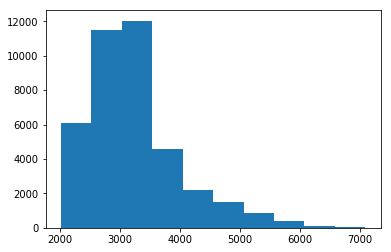

In [15]:
plt.hist(df.demand)

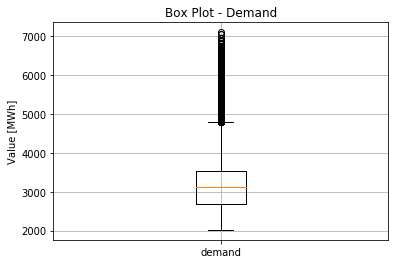

In [16]:
plt.boxplot([df['demand']], labels=['demand'])
plt.title('Box Plot - Demand')
plt.ylabel('Value [MWh]')
plt.grid(True)

In [17]:
# get pearson correlation coefficients for demand
print('DEMAND CORRELATIONS (PEARSON)')
print(df.corr()['demand'].sort_values(ascending=False)[1:])

# get r^2 values per column and print
demand_r = {}
for col in df.columns:
    if col != 'demand':
        if col != 'date':
            slope, intercept, r_value, p_value, std_err = scipy.stats.stats.linregress(df['demand'], df[col])
            demand_r[col] = float(r_value**2)

print(' ')
print('***')
print(' ')
print('DEMAND CORRELATIONS (r^2)')
demand_r_df = pd.DataFrame({'col': list(demand_r.keys()), 'r^2': list(demand_r.values())})
print(demand_r_df.sort_values(by='r^2', ascending=False))

DEMAND CORRELATIONS (PEARSON)
dailycoolingdegreedays       0.555986
hourlyrelativehumidity       0.366542
hourlydewpointtemperature    0.363027
hourlyskyconditions_CLR      0.031848
hourlydrybulbtemperature     0.007155
hourlyskyconditions_OVC      0.006755
hourlyvisibility            -0.006148
hourlyprecipitation         -0.020062
hourlyskyconditions_BKN     -0.030838
hourlyskyconditions_SCT     -0.035265
hourlyskyconditions_FEW     -0.036816
hourlycoolingdegrees        -0.053830
hourlyheatingdegrees        -0.078664
dailyheatingdegreedays      -0.212006
hourlystationpressure       -0.227163
hourlywindspeed             -0.228085
hourlysealevelpressure      -0.230413
Name: demand, dtype: float64
 
***
 
DEMAND CORRELATIONS (r^2)
                          col       r^2
0      dailycoolingdegreedays  0.309121
5      hourlyrelativehumidity  0.134353
2   hourlydewpointtemperature  0.131789
6      hourlysealevelpressure  0.053090
9             hourlywindspeed  0.052023
7       hourlystation

In [18]:
# here we store summary statistics of all the columns in a separate df for visualization
df_eda = df.copy()
stds = df_eda.std()
means = df_eda.mean()
medians = df_eda.median()

df_stats = pd.DataFrame({'std': stds, 'mean': means, 'median': medians})
print(df_stats.sort_values('std', ascending=False))

                                  std         mean   median
demand                     751.045968  3238.293327  3116.00
hourlyrelativehumidity      20.294544    62.582294    66.00
hourlydewpointtemperature   11.660381    50.905021    54.00
hourlydrybulbtemperature     9.339298    66.209439    66.00
hourlycoolingdegrees         6.239647     4.228792     0.00
dailycoolingdegreedays       5.453437     4.778347     3.00
hourlyheatingdegrees         4.737582     3.062776     0.00
dailyheatingdegreedays       3.547808     2.067034     0.00
hourlywindspeed              2.409212     1.584130     0.00
hourlyvisibility             1.804823     9.192254    10.00
hourlyskyconditions_CLR      0.449871     0.718223     1.00
hourlyskyconditions_OVC      0.390775     0.188072     0.00
hourlyskyconditions_BKN      0.199705     0.041612     0.00
hourlyskyconditions_FEW      0.165402     0.028150     0.00
hourlyskyconditions_SCT      0.146866     0.022056     0.00
hourlysealevelpressure       0.109281   

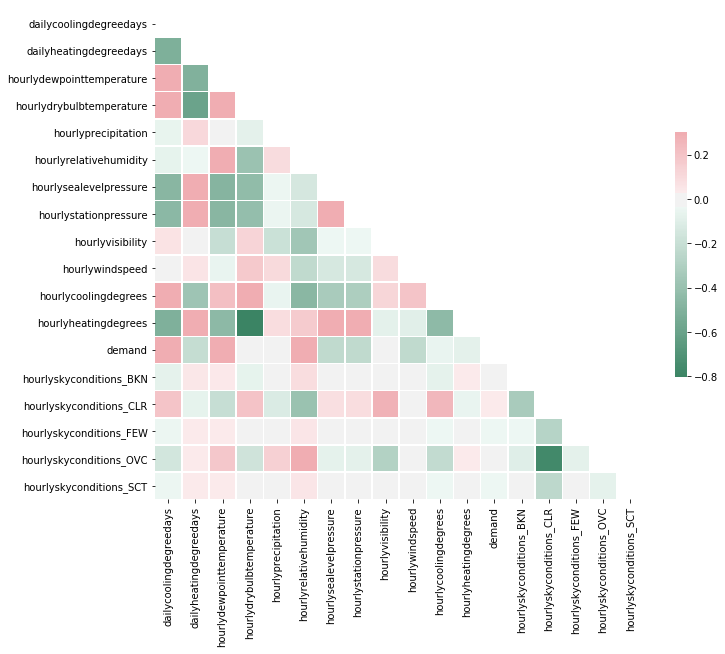

In [19]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(150, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Generating OLS Regression

In [20]:
def multiple_regression(df):
    X = df[[col for col in df.columns if col != 'demand']]
    y = df['demand']
    X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model
    
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    print(model.summary())
    return model

mreg = multiple_regression(df)

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     5020.
Date:                Fri, 17 Jan 2020   Prob (F-statistic):               0.00
Time:                        19:25:14   Log-Likelihood:            -2.9267e+05
No. Observations:               39219   AIC:                         5.854e+05
Df Residuals:                   39201   BIC:                         5.855e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


In [21]:
df = df.drop(['hourlysealevelpressure', 'hourlystationpressure', 'hourlyskyconditions_OVC', 'hourlyskyconditions_CLR'], axis=1)

In [22]:
# save as csv file to continue in another notebook
s3_resource = boto3.resource('s3')

df_buffer = io.StringIO()
df_key = 'dataframes/%s_dataset.csv' % CITY
df.to_csv(df_buffer, compression=None)

s3_resource.Object(bucket, df_key).put(Body=df_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '2417501411FBFB33',
  'HostId': 'O2tS0nm2xtJ+fRR6YGUB/gHXfEl4mGfBnc+HjK5BzTWtXzZPecdMBTLb7wgN6NleIXNalMoYgow=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'O2tS0nm2xtJ+fRR6YGUB/gHXfEl4mGfBnc+HjK5BzTWtXzZPecdMBTLb7wgN6NleIXNalMoYgow=',
   'x-amz-request-id': '2417501411FBFB33',
   'date': 'Fri, 17 Jan 2020 19:25:21 GMT',
   'etag': '"f6f1752c54def004c78512b6cc6ff333"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"f6f1752c54def004c78512b6cc6ff333"'}